# TP2 - Realidade Aumentada

Aluno: Vinicius Silva Gomes

Matrícula: 2021421869

In [1]:
# Importing libraries

import numpy as np
import cv2
import os

import matplotlib.pyplot as plt

from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

from PIL import Image

from objloader import *

pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Extraindo frames do vídeo para calibração

Esse pequeno script foi feito para extrair os frames do vídeo e usá-los para calibrar a câmera e obter os parâmetros intrínsecos da câmera. O script, em suma, carrega o vídeo, usando o OpenCV, e salva cada frame no disco, em uma pasta chamada ./fames.

Dessa pasta, foram escolhidos 6 frames que apresentavam angulações, distâncias e rotações diferentes do tabuleiro xadrez e esses frames foram separados para serem usados na calibração da câmera.

OBS: Para que as imagens sejam salvas, a pasta ./frames precisa ter sido criada previamente.

In [ ]:
# Extract frames from the video

cam = cv2.VideoCapture("./entrada.mp4")

current_frame = 0

while(True):
    ret, frame = cam.read()

    if ret:
        # A ./frames/ folder must exist for this code to work
        name = './frames/frame' + str(current_frame) + '.jpg'
        print ('Creating... ' + name)
  
        cv2.imwrite(name, frame)
  
        current_frame += 1
    else:
        break

cam.release()
cv2.destroyAllWindows()

## Obtendo os parâmetros intrínsecos

Com os frames selecionados, foi usado o MatLAB para obter os parâmetros intrísecos da câmera. A opção "Camera Calibration" foi a escolhida. Os pontos do tabuleiro foram selecionados e após o mapeamento e as devidas funções internas do MatLAB terem sido executadas, a matriz de parâmetros intrínsecos foi obtida.

A próxima célula apresenta a declaração dessa matriz com os dados de output do MatLAB.

<!-- OBS: A matriz foi transposta para se parecer com a matriz que foi estudada e usada como exemplo ao longo das aulas da disciplina. -->

In [2]:
intrinsic = np.array(([412.529325914068, 0, 315.182970634010],
                     [0, 409.199483018995, 225.068598819594],
                     [0, 0, 1]))

print(intrinsic)

[[412.52932591   0.         315.18297063]
 [  0.         409.19948302 225.06859882]
 [  0.           0.           1.        ]]


## Localizando os alvos ao longo do vídeo

In [38]:
template = cv2.imread("./alvo.jpg", 0)

def comparison_target_left(src):
    copy = template.copy()
    left = cv2.rotate(copy, cv2.ROTATE_90_COUNTERCLOCKWISE)

def comparison_target_up(src):
    copy = template.copy()
    up = copy
    
def comparison_target_right(src):
    copy = template.copy()
    right = cv2.rotate(copy, cv2.ROTATE_90_CLOCKWISE)
    
def comparison_target_down(src):
    copy = template.copy()
    down = cv2.rotate(copy, cv2.ROTATE_180)

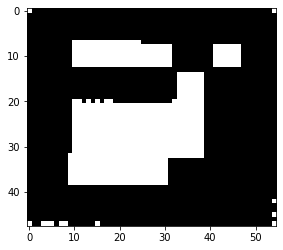

In [37]:
cam = cv2.VideoCapture("./entrada.mp4", 0)

while(True):
    ret, frame = cam.read()
    
    if ret:
        copy = frame.copy()
        gray_frame = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
        
        _, thresh = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)
        
        edged = cv2.Canny(thresh, 30, 200)
        contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        target_contour = []
        
        for contour in contours:
            hull = cv2.convexHull(contour)
            
            perimeter = cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, 0.1 * perimeter, True)
            no_vertices = len(approx)
            
            if (perimeter > 100 and perimeter < 1000) and no_vertices == 4:
                target_contour.append(approx)
                
        cv2.drawContours(copy, target_contour, -1, (0, 255, 0), 2)
        
        for single_contour in target_contour:
            pts = single_contour.reshape(4, 2)
            rect = np.zeros((4, 2), dtype = "float32")
            
            s = pts.sum(axis = 1)
            rect[0] = pts[np.argmin(s)]
            rect[2] = pts[np.argmax(s)]
            
            diff = np.diff(pts, axis = 1)
            rect[1] = pts[np.argmin(diff)]
            rect[3] = pts[np.argmax(diff)]
            
            # now that we have our rectangle of points, let's compute
            # the width of our new image
            (tl, tr, br, bl) = rect
            widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
            widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
            # ...and now for the height of our new image
            heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
            heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
            # take the maximum of the width and height values to reach
            # our final dimensions
            maxWidth = max(int(widthA), int(widthB))
            maxHeight = max(int(heightA), int(heightB))
            # construct our destination points which will be used to
            # map the screen to a top-down, "birds eye" view
            dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]], dtype = "float32")
            # calculate the perspective transform matrix and warp
            # the perspective to grab the screen
            M = cv2.getPerspectiveTransform(rect, dst)
            warp = cv2.warpPerspective(gray_frame, M, (maxWidth, maxHeight))
            
            _, thresh_warp = cv2.threshold(warp, 127, 255, cv2.THRESH_BINARY)
            
            plt.imshow(thresh_warp, cmap='gray')
            plt.show()
            
            break

#         plt.imshow(copy, cmap='gray')
#         plt.show()
        
        break
    else:
        break

cam.release()
cv2.destroyAllWindows()

## Obtendo os parâmetros extrínsecos

In [6]:
 def initOpenGL(dimensions):
    (width, height) = dimensions
    
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
 
    fovy = 45
    aspect = (width)/(height)
    gluPerspective(fovy, aspect, 0.1, 100.0)
        
# def object3D(obj):
#     # translada o objeto para ficar 10 unidades distante da camera (para podermos ver o objeto)
#     glTranslate(0,0,-10)

#     # move o model em y para centralizar ele
#     glTranslate(0,-2,0)
#     # rotaciona o modelo para podermos ve-lo de frente
#     #glRotate(90,1,0,0)
#     glRotate(180,0,1,0)
#     # renderiza o modelo do Pikachu
#     glCallList(obj.gl_list)

#     # renderiza um cubo
#     # glutWireCube(2.0)

    
def displayCallback():
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    # carregar o modelo 3D do Pikachu
    obj = OBJ("Pikachu.obj", swapyz=True)

    # habilita o uso de texturas (o Pikachu tem textura)
    glEnable(GL_TEXTURE_2D)

#     object3D(obj) 
        
    glutSwapBuffers()    
    

def idleCallback():
    glutPostRedisplay()

In [7]:
dimensions = (640, 480)

glutInit()
glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)

glutInitWindowSize(*dimensions)

window = glutCreateWindow(b'TP2 - Realidade Aumentada - Vinicius Gomes')
initOpenGL(dimensions)

glutDisplayFunc(displayCallback)
glutIdleFunc(idleCallback)

glutMainLoop()